# Production Notebook: Generate regridding weights

We have now more memory available on the cloud instances, so Ill rerun this in a more permanent fashion.


In [19]:
import json
import gcsfs
import xarray as xr
import xesmf as xe

## Set up the target cloud bucket and folder

In [20]:
# # 👇 replace with your key 
# with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
#     token = json.load(token_file)
# fs = gcsfs.GCSFileSystem(token=token)
fs = gcsfs.GCSFileSystem()

## Load source data

In [21]:
# load the ocean data
kwargs = dict(consolidated=True, use_cftime=True)
ds_flux = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/ocean_boundary', **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_grid  = xr.open_zarr('gs://cmip6/GFDL_CM2_6/grid', **kwargs)

In [32]:
ocean_sample = ds_flux.isel(time=slice(0,3))
ocean_sample = ocean_sample.drop([co for co in ocean_sample.coords if co not in ['geolon_t','geolat_t']])
display(ocean_sample)

atmos_sample = ds_atmos.isel(time=slice(0,3)).rename({'grid_xt':'lon', 'grid_yt':'lat'})
atmos_sample = atmos_sample.drop([co for co in atmos_sample.coords if co not in ['lon','lat']])

<xarray.Dataset>
Dimensions:                    (time: 3, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
Dimensions without coordinates: time, yu_ocean, xu_ocean, yt_ocean, xt_ocean
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

## Part 1: Generate a regridder from atmosphere to ocean resolution

In [31]:
nc_filename = 'CM26_atmos2ocean_weights.nc'
regridder = xe.Regridder(
    atmos_sample,
    ocean_sample,
    'bilinear',
    periodic=True,
    filename=nc_filename
)

KeyboardInterrupt: 

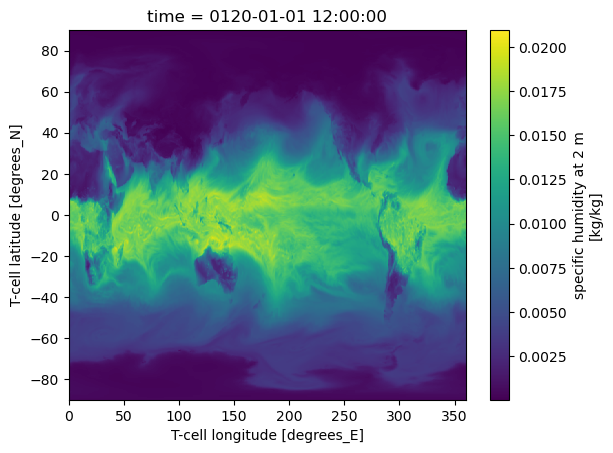

In [26]:
ds_atmos.q_ref.isel(time=0).plot()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('grid_yt', 'grid_xt') from data variable WVP as the horizontal dimensions for the regridding.
  warnings.warn(


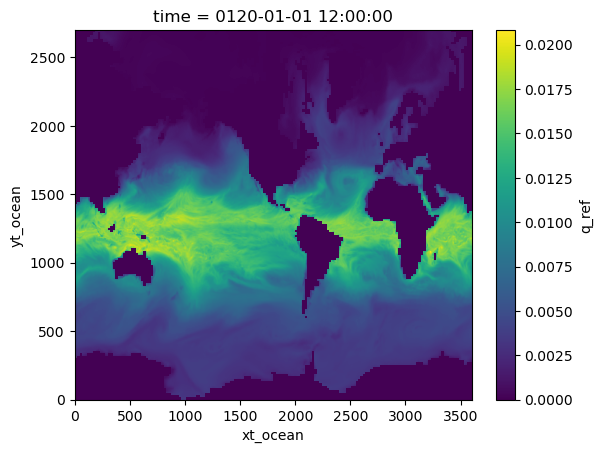

In [27]:
regridder(ds_atmos.isel(time=0)).q_ref.plot()

In [6]:
# write zarr store from the regridder file
ds = xr.open_dataset(nc_filename)
mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr')
ds.to_zarr(mapper, mode='w')
xr.open_dataset(mapper, engine='zarr')

<xarray.Dataset>
Dimensions:  (n_s: 27076148)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

## Part 2: Generate separate regridders from ocean/atmosphere to 2x2 def grid

TBD